In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import os

### data functions

In [ ]:
def gen_data(L, N_ax, xmin, xmax, ymin, ymax):
    """
    Generates an xy grid of collocation and boundary condition data.
    """

    Lhalf = L / 2 
    dx = 2 * Lhalf / N_ax  # step size

    # collocation midpoints
    x = np.linspace(-Lhalf + dx/2, Lhalf - dx/2, N_ax) + Lhalf
    y = np.linspace(-Lhalf + dx/2, Lhalf - dx/2, N_ax) + Lhalf

    # b.c. data
    xmin_bc = np.concatenate([np.array([xmin] * y.shape[0]).reshape(-1, 1), y.reshape(-1, 1)], axis=1)
    xmax_bc = np.concatenate([np.array([xmax] * y.shape[0]).reshape(-1, 1), y.reshape(-1, 1)], axis=1)
    ymin_bc = np.concatenate([x.reshape(-1, 1), np.array([ymin] * x.shape[0]).reshape(-1, 1)], axis=1)
    ymax_bc = np.concatenate([x.reshape(-1, 1), np.array([ymax] * x.shape[0]).reshape(-1, 1)], axis=1)
    bc_data = np.concatenate([xmin_bc, xmax_bc, ymin_bc, ymax_bc])
    bc_data = np.concatenate([bc_data, [[xmin, 0]], [[xmin, L]], [[xmax, 0]], [[xmax, L]]])  # 4 additional b.c. points not generated above (NOTE hardcoded assumption 0 is min and L is max on both axes)
    bc_u = np.array([0.] * bc_data.shape[0]).reshape(-1, 1)

    # 2D meshgrid
    coll_data = np.stack(np.meshgrid(x, y, indexing='ij'), axis=-1).reshape(-1, 2) 

    return coll_data, bc_data, bc_u, dx

def perturb(vals, minimum, maximum, perturb_delta):
    # add noise to vals
    noise = torch.randn_like(vals) * perturb_delta
    new_vals = vals + noise
    
    # if perturbed vals fall outside of vals domain, move them back in
    new_vals.data[new_vals < minimum] = minimum - new_vals.data[new_vals < minimum]  
    new_vals.data[new_vals > maximum] = 2 * maximum - new_vals.data[new_vals > maximum]  

    return new_vals

def perturb_data(data, perturb_delta=0.01):
    new_data = torch.ones_like(data)
    minimums = [torch.min(data[:, i]).item() for i in range(data.shape[1])]
    maximums = [torch.max(data[:, i]).item() for i in range(data.shape[1])]
    perturb_deltas = [(torch.max(data[:, i]) - torch.min(data[:, i])).item() * perturb_delta for i in range(data.shape[1])]

    for i in range(data.shape[1]):
        new_data[:, i] = perturb(data[:, i], minimums[i], maximums[i], perturb_delta=perturb_deltas[i])

    return new_data

### generate data

(1600, 2)


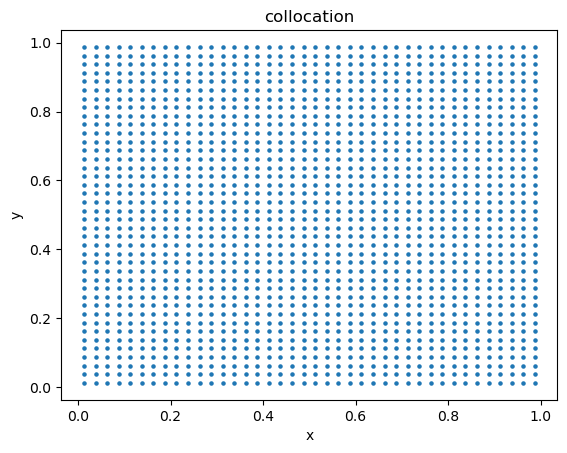

(164, 2)


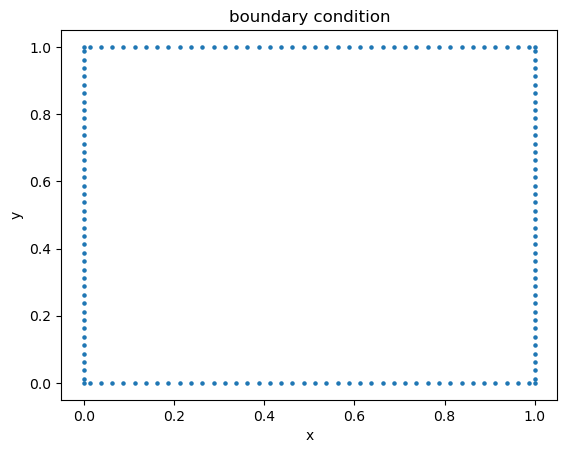

In [10]:
# set gpu
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# generate grid of data
L = 1
#N_ax = 100
N_ax = 40
xmin = 0
xmax = 1
ymin = 0
ymax = 1
coll_data, bc_data, bc_u, dx = gen_data(L, N_ax, xmin, xmax, ymin, ymax)

# visualize data
print(coll_data.shape)
plt.title("collocation")
plt.scatter(coll_data[:, 0], coll_data[:, 1], s=5)
plt.xlabel("x")
plt.ylabel("y")
plt.show()
print(bc_data.shape)
plt.title("boundary condition")
plt.scatter(bc_data[:, 0], bc_data[:, 1], s=5)
plt.xlabel("x")
plt.ylabel("y")

coll_data = torch.tensor(coll_data, requires_grad=True).to(device)
bc_data = torch.tensor(bc_data, requires_grad=True).to(device)
bc_u = torch.tensor(bc_u, requires_grad=True).to(device)

### loss class definition

In [4]:
class PINNLoss(nn.Module):
    def __init__(self):
        super(PINNLoss, self).__init__()
        self.loss = None

        # NOTE if you change loss terms returned, must change this and return+calculations in calc_loss()
        self.return_names = ["loss_ovr", "loss_ovr_no_reg", "loss_f", "loss_bc", "u_trivial_penalty"]
    
    def MSE_f(self, f_pred):
        """
        Returns MSE loss on f predictions. 

        Inputs:
        f_pred: batch of differential equation predictions
        """

        return torch.mean(f_pred**2)

    def MSE_bc(self, u_target, u_pred):
        """
        Returns MSE loss on b.c. predictions.

        Inputs:
        u_target: actual value of u
        u_pred: batch of predicted u values at b.c. points
        """

        return torch.mean((u_target - u_pred)**2)

    def calc_u_trivial_penalty(self, u_pred):
        """
        Returns a term that penalizes trivial solutions.

        Inputs:
        u_pred: batch of wavefunction predictions
        """

        return (1 / torch.mean(u_pred**2 + 1e-6))

    def calc_loss(self, u_coll_pred, f_pred, u_bc_target, u_bc_pred):
        """
        Calculate loss terms for predictions. Returns a tuple of losses. 
        Names and order of returned terms should match self.return_names.

        Inputs:
        u_coll_pred: batch of wavefunction predictions 
        f_pred: batch of differential equation predictions (only generated from collocation data)
        u_bc_target: actual u values for b.c. data
        u_bc_pred: batch of b.c. wavefunction predictions
        """

        # differential equation MSE loss (collocation)
        loss_f = self.MSE_f(f_pred)

        # trivial solution penalty (collocation)
        u_trivial_penalty = self.calc_u_trivial_penalty(u_coll_pred)

        # b.c. MSE loss
        loss_bc = self.MSE_bc(u_bc_target, u_bc_pred)

        # overall loss
        loss_ovr = loss_f + loss_bc + u_trivial_penalty 

        # loss w/o regularization terms
        loss_ovr_no_reg = loss_f + loss_bc

        return loss_ovr, loss_ovr_no_reg, loss_f, loss_bc, u_trivial_penalty

### PINN class definition

In [ ]:
class SinActivation(torch.nn.Module):
    @staticmethod
    def forward(input):
        """
        Passes input tensor through sin function. Used in neural network class.

        Inputs:
        input: tensor batch of layer outputs
        """

        return torch.sin(input)

class PINN(nn.Module):
    def __init__(self, input_size, device, L, E=None, num_hidden_layers=4, optimizer_lr=0.0001, optimizer_betas=(0.999, 0.9999)):
        super(PINN, self).__init__()

        # constants
        self.planck_term_constant = 0.5  # hbar**2/2*m in Coulomb units

        # maximum r in data
        self.L = L

        # NOTE assuming square (this should be refactored as an input)
        self.x_min = 0
        self.y_min = 0
        self.x_max = L
        self.y_max = L

        # torch device
        self.device = device

        # E initialization
        self.E = E 

        # network
        self.activation = SinActivation()
        self.dense0 = nn.Linear(input_size + 1, 64, dtype=torch.double)  # NOTE +1 to input shape for implicit E value
        self.hidden_layers = nn.ModuleList([nn.Linear(64, 64, dtype=torch.double) for _ in range(num_hidden_layers)])  # NOTE new
        self.dense_out = nn.Linear(64, 1, dtype=torch.double)

        # optimizer + loss
        self.optimizer = optim.Adam(self.parameters(), lr=optimizer_lr, betas=optimizer_betas)
        self.loss_criteria = PINNLoss()
        self.loss = None

    def forward_net(self, data):
        """
        Forward pass through full network. Returns network output.

        Inputs:
        data: tensor with correct input shape
        """

        out = self.dense0(data)
        out = self.activation(out)
        for hidden_layer in self.hidden_layers:
            out = hidden_layer(out)
            out = self.activation(out)
        out = self.dense_out(out)
        
        return out

    def forward(self, x, y):
        """
        Full PINN forward pass that includes E concat, network forward pass, network output b.c. scaling, 
        gradient calculations, and diff. eqn. (f) calculation.
        Returns final output prediction, u, and f.

        Inputs:
        x: tensor of x with shape (N, 1)
        y: tensor of y with shape (N, 1)
        """

        # create E input vector
        E_batch = torch.tensor([[self.E]] * x.shape[0]).to(self.device)

        # concat inputs for network (need them separate initially for grad calc later)
        nn_inp = torch.cat([x, y, E_batch], dim=1)

        # pass through nn
        u = self.forward_net(nn_inp)

        # calc gradients
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]

        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), retain_graph=True, create_graph=True)[0]
        
        # differential equation
        f = self.planck_term_constant * (u_xx + u_yy) + (self.E * u)
        
        return u, f

    def forward_inference(self, x, y):
        """
        Inference forward pass. Doesn't include gradient + f calculation.

        Inputs:
        x: tensor of x with shape (N, 1)
        y: tensor of y with shape (N, 1)
        """

        # create E input vector
        E_batch = torch.tensor([[self.E]] * x.shape[0]).to(self.device)

        # concat inputs for network 
        nn_inp = torch.cat([x, y, E_batch], dim=1)

        # pass through nn
        u = self.forward_net(nn_inp)

        return u

    def backward(self, u_coll_pred, f_pred, u_bc_target, u_bc_pred):
        """
        Network backward pass. Returns tuple of loss values.
        
        Inputs:
        u_coll_pred: batch of collocation wavefunction predictions 
        f_pred: batch of differential equation predictions
        u_bc_target: actual u values for b.c. data
        u_bc_pred: batch of b.c. wavefunction predictions
        """

        # calculate losses
        losses = self.loss_criteria.calc_loss(u_coll_pred, f_pred, u_bc_target, u_bc_pred)
        self.loss = losses[0]  # NOTE overall loss should always be first value returned in losses tuple

        # backprop + update params
        self.loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        return losses 

### plotting functions

In [6]:
def display_plot(x_vals, y_vals, x_label="x", y_label="y", line_color="b", log_scale=False, data_label=None, title=None):
    """
    Generate plot for x_vals and y_vals.

    Inputs:
    pretty self-explanatory
    """

    if data_label:
        plt.plot(x_vals, y_vals, color=line_color, label=data_label)
        plt.legend()
    else:
        plt.plot(x_vals, y_vals, color=line_color)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    if log_scale:
        plt.yscale("log")

    plt.show()

### train loop function

In [ ]:
def run_train_loop(coll_data, 
                   bc_data,
                   bc_u,
                   device, 
                   L, 
                   E_range,
                   num_train_steps_per_E,
                   save_denom=1000,
                   loss_criteria_idx=0,
                   num_hidden_layers=4):
    start_time = time.time()
    print(f"training network on {len(E_range)} values of E with {num_train_steps_per_E} train steps per E...")
    epoch = 0
    epoch_print_denom = 1000

    # initialize network
    lr = 8e-3
    betas = (0.999, 0.9999)
    pinn = PINN(coll_data.shape[1], device, L, optimizer_lr=lr, optimizer_betas=betas, num_hidden_layers=num_hidden_layers)
    pinn.to(device)
    
    # initialize copy of current network (used for tracking best model across training)
    current_best_pinn = PINN(coll_data.shape[1], device, L, E=pinn.E, optimizer_lr=lr, optimizer_betas=betas, num_hidden_layers=num_hidden_layers).to(device)
    current_best_pinn.load_state_dict(pinn.state_dict())

    # best model save variables
    min_save_epoch = 100
    prev_pinns = []  # list to store best models 
    default_min_loss = 1000
    min_loss = default_min_loss
    current_best_epoch = -1

    E_predictions = []  # track E by training step (epoch)
    train_loss_vals = []  # track all loss values across training

    for E_idx, E in enumerate(E_range):
        pinn.E = E
        
        for train_step in range(num_train_steps_per_E):

            # perturb data
            coll_perturbed = perturb_data(coll_data).to(device)

            # collocation forward pass
            u_coll_pred, f_pred = pinn.forward(coll_perturbed[:, 0].reshape(-1, 1), 
                                               coll_perturbed[:, 1].reshape(-1, 1))

            # b.c. forward pass
            u_bc_pred = pinn.forward_inference(bc_data[:, 0].reshape(-1, 1),
                                               bc_data[:, 1].reshape(-1, 1))

            # backward pass
            losses = pinn.backward(u_coll_pred, f_pred, bc_u, u_bc_pred)
            train_loss_vals.append([loss_val.item() for loss_val in losses])

            # track E
            E_predictions.append(E)
            
            ####
            # check if new minimum overall loss attained across this window of epochs
            if (epoch >= min_save_epoch) and (losses[loss_criteria_idx] < min_loss):
                # update current best loss and epoch
                min_loss = losses[loss_criteria_idx]
                current_best_epoch = epoch
                
                # copy current model state 
                current_best_pinn = PINN(coll_data.shape[1], device, L, E=pinn.E, optimizer_lr=lr, optimizer_betas=betas, num_hidden_layers=num_hidden_layers).to(device)
                current_best_pinn.load_state_dict(pinn.state_dict())

            # save the best (min loss) model across this window of epochs
            if (epoch >= min_save_epoch) and ((epoch + 1) % save_denom == 0):
                min_loss = default_min_loss  # reset min loss to default (ideally next best model beats quickly) 

                # copy this epoch window's best model state and save (model, epoch) tuple to list
                pinn_copy = PINN(coll_data.shape[1], device, L, E=current_best_pinn.E, optimizer_lr=lr, optimizer_betas=betas, num_hidden_layers=num_hidden_layers).to(device)
                pinn_copy.load_state_dict(current_best_pinn.state_dict())
                prev_pinns.append((pinn_copy, current_best_epoch))

                # NOTE I don't reset current_best_pinn here. so if model in next window doesn't beat default min loss, best model from previous window is saved
            ####

            if ((epoch == 0) or ((epoch + 1) % epoch_print_denom == 0)):
                print("\n" + "=" * 20 + f" EPOCH {epoch} " + "=" * 20)
                print()
                print("train losses:")
                for return_name, val in zip(pinn.loss_criteria.return_names, train_loss_vals[epoch]):
                    print(f"{return_name} = {val:.3e}")
                print()
                print(f"current E = {pinn.E.item()}")
                print(f"elapsed model training time: {(time.time() - start_time) / 60 :.2f} minutes")

            epoch += 1

    # plot losses
    epoch_list = [e for e in range(epoch)]
    for loss_idx, loss_name in enumerate(pinn.loss_criteria.return_names):
        display_plot(epoch_list,
                     torch.tensor(train_loss_vals)[:, loss_idx].detach().numpy(),
                     x_label="epoch",
                     y_label=loss_name,
                     log_scale=True)

    # plot E
    display_plot(epoch_list, E_predictions, x_label="epoch", y_label=r"$\hat{E}$")

    return prev_pinns, train_loss_vals, epoch

### train model(s)

In [5]:
def calc_E(nx, ny):
    # Coulomb units: hbar**2/2m * pi**2/L**2 == 0.5 * pi**2/L**2
    return (0.5 * np.pi**2 / L**2) * (nx**2 + ny**2)

nx_ny_pairs = [(1, 1), (2, 1), (2, 2), (3, 1)]
E_range = np.array([calc_E(nx, ny) for nx, ny in nx_ny_pairs])  # Coulomb units
E_delta = 0.1
E_range = np.array([[E - E_delta, E, E + E_delta] for E in E_range]).flatten()

In [6]:
E_range

array([ 9.7696044 ,  9.8696044 ,  9.9696044 , 24.574011  , 24.674011  ,
       24.774011  , 39.3784176 , 39.4784176 , 39.5784176 , 49.24802201,
       49.34802201, 49.44802201])

training network on 12 values of E with 30000 train steps per E...

==================== EPOCH 0 ====================

train losses:
loss_ovr = 3.637e+01
loss_ovr_no_reg = 2.809e+00
loss_f = 2.779e+00
loss_bc = 2.977e-02
u_trivial_penalty = 3.356e+01

current E = 9.769604401089358
elapsed model training time: 0.01 minutes

==================== EPOCH 999 ====================

train losses:
loss_ovr = 3.477e+00
loss_ovr_no_reg = 1.378e+00
loss_f = 9.580e-01
loss_bc = 4.196e-01
u_trivial_penalty = 2.100e+00

current E = 9.769604401089358
elapsed model training time: 0.19 minutes

==================== EPOCH 1999 ====================

train losses:
loss_ovr = 1.162e+00
loss_ovr_no_reg = 5.414e-01
loss_f = 3.805e-01
loss_bc = 1.609e-01
u_trivial_penalty = 6.202e-01

current E = 9.769604401089358
elapsed model training time: 0.37 minutes

==================== EPOCH 2999 ====================

train losses:
loss_ovr = 5.764e-01
loss_ovr_no_reg = 2.857e-01
loss_f = 1.088e-01
loss_bc = 1.770e-01


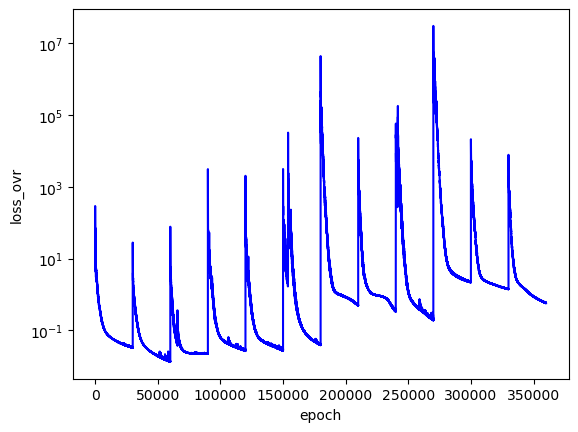

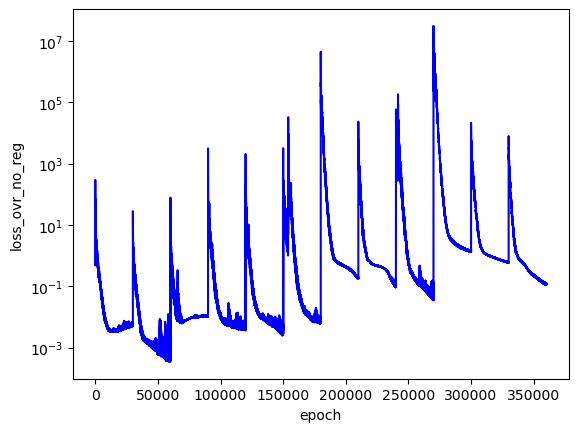

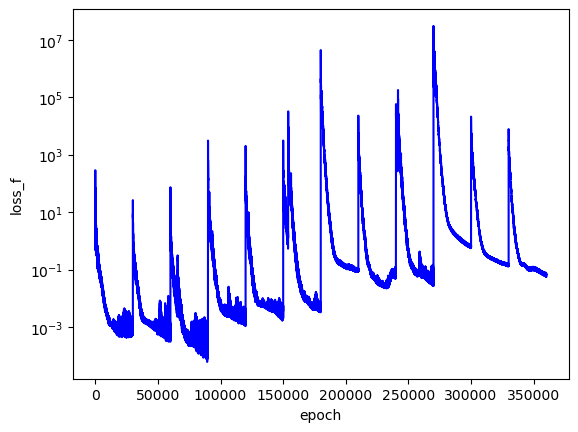

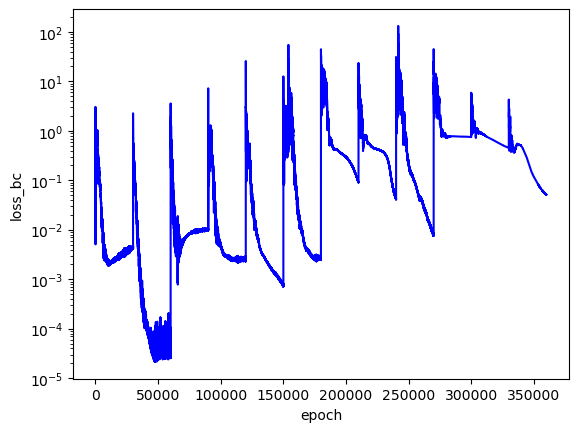

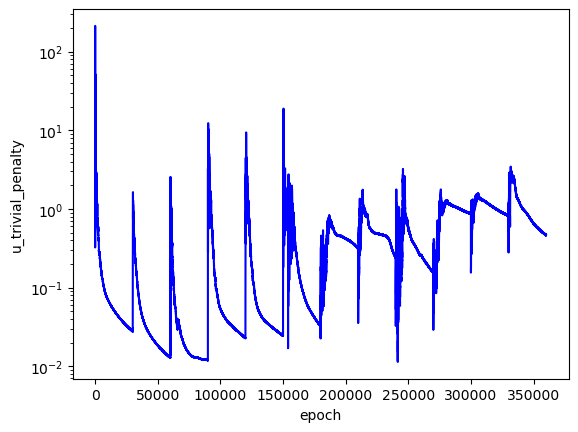

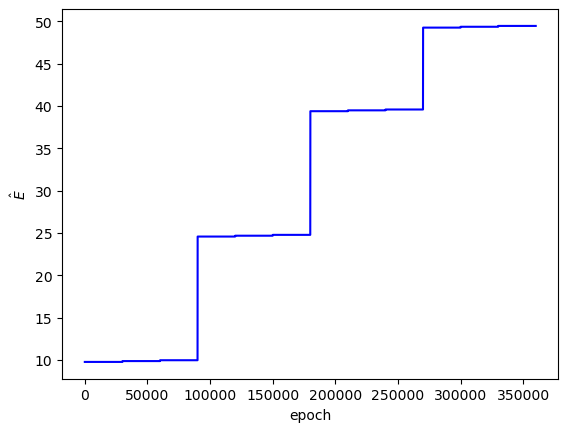

In [ ]:
num_train_steps_per_E = 30000
loss_criteria_idx = 1
saved_pinns, train_loss_vals, num_epochs = run_train_loop(coll_data, 
                                                          bc_data,
                                                          bc_u,
                                                          device, 
                                                          L, 
                                                          E_range, 
                                                          num_train_steps_per_E, 
                                                          loss_criteria_idx=loss_criteria_idx, 
                                                          num_hidden_layers=2)

### get best model(s) and evaluate predictions

In [10]:
def get_best_pinns(min_loss_windows, pinns, train_loss_vals, loss_criteria_idx):
    """
    Plots model with minimum loss (based on loss_criteria_idx) in each window of min_loss_windows.
    Returns list of dictionaries containing the best models + relevant info.

    Inputs:
    min_loss_windows: list of tuples where each tuple is a range of epoch values to look for model with minimum loss
    pinns: list of all saved torch models across training
    train_loss_vals: list of tuples containing loss values for each training epoch
    loss_criteria_idx: index of loss term to use for evaluating best model to save (see PINNLoss)
    """

    ovr_losses = torch.tensor(train_loss_vals)[:, loss_criteria_idx].detach().numpy()
    eigen_pinns = []  # list to save best models to (assuming each model saved below corresponds to unique eigenvalue)

    for (start, stop) in min_loss_windows:
        # find the epoch where the minimum overall loss is achieved
        epoch_idx = np.argmin(ovr_losses[start:stop]) + start

        if (len(pinns) == 0):
            print("No models saved during training.")
        else:
            # get the matching model (this should always hit i think as long as there is a match)
            p_list = [(net, epoch_num) for (net, epoch_num) in pinns if epoch_num == epoch_idx]

            if (len(p_list) == 0):
                print(f"No matching saved models found for epoch window [{start}, {stop}] with minimum epoch = {epoch_idx}. Check self-defined minimum loss windows.")
            else:
                # matching model found
                p = p_list[0]
                
                # save this predicted eigen solution
                eigen_pinns.append({"model": p[0], "epoch": epoch_idx, "losses": train_loss_vals[epoch_idx]})
    
    return eigen_pinns

In [ ]:
loss_windows = [[100 + (i*num_train_steps_per_E * 3), (i*num_train_steps_per_E + num_train_steps_per_E) * 3] for i in range(4)]  # NOTE hardcoding
best_pinns = get_best_pinns(loss_windows, saved_pinns, train_loss_vals, loss_criteria_idx)

In [ ]:
def calc_analytical(x, y, n_x, n_y, L):
    return (2 / L) * np.sin(n_x * np.pi * x / L) * np.sin(n_y * np.pi * y / L)

def calc_pred_norm_const(approx_domain_pred_vec, d):
    return 1. / torch.sqrt(d**2 * torch.sum(approx_domain_pred_vec**2))

def eval_pinn(pinn_dict, coll_data, bc_data, nx, ny):
    print("=" * 100)
    print(f"PINN saved on epoch {pinn_dict['epoch']}")
    print(f"E = {pinn_dict['model'].E}")
    
    for loss_val, loss_name in zip(pinn_dict["losses"], pinn_dict["model"].loss_criteria.return_names):
        print(f"{loss_name} = {loss_val}")

    # combine bc+coll data for inference
    xy_data = torch.concat([coll_data, bc_data])

    # make predictions and normalize
    pinn = pinn_dict["model"]
    u_pred = pinn.forward_inference(xy_data[:, 0].reshape(-1, 1), xy_data[:, 1].reshape(-1, 1))
    pred_norm_const = calc_pred_norm_const(u_pred, dx)  # TODO is dx correct here? check against data gen
    u_pred = u_pred * pred_norm_const
    u_pred = u_pred.flatten().detach().cpu().numpy()
    u_pred_prob_densities = u_pred**2
    x = xy_data[:, 0].detach().cpu().numpy()
    y = xy_data[:, 1].detach().cpu().numpy()

    # analytical solution
    #nx = 1
    #ny = 3
    u_analytical = calc_analytical(x, y, nx, ny, L)
    u_analytical_prob_densities = u_analytical**2
    bohr_radius = 1  # Coulomb units

    # sign flip
    flip_val = np.round(np.mean(u_analytical / (u_pred + 1e-6)))

    if int(flip_val) < 0:
        flipped_sign = True
        u_pred = -u_pred
    else:
        flipped_sign = False

    # MSE calc
    mse = np.mean((u_analytical - u_pred)**2)

    print(f"flip val = {flip_val}")
    print(f"flipped sign = {flipped_sign}")
    print(f"MSE = {mse}")

    # predicted u
    plt.close()
    fig = plt.figure(figsize=(8, 6), constrained_layout=True)
    ax = fig.add_subplot(projection='3d')
    scatter_ax = ax.scatter(x, y, u_pred, c=u_pred_prob_densities, cmap="Reds")
    colorbar = fig.colorbar(scatter_ax, shrink=0.55, aspect=6, pad=0.1)
    colorbar.set_label(r"$|\hat{\psi}(x,y)|^2$", labelpad=30)
    colorbar.ax.yaxis.label.set_rotation(0)
    ax.set_xlabel("x", weight="bold")
    ax.set_ylabel("y", weight="bold")
    ax.set_zlabel(r"$\hat{\psi}(x,y)$", weight="bold")
    ax.zaxis.labelpad = 10
    ax.set_box_aspect(aspect=None, zoom=0.9)  
    plt.show()

    # analytical u
    plt.close()
    fig = plt.figure(figsize=(8, 6), constrained_layout=True)
    ax = fig.add_subplot(projection='3d')
    scatter_ax = ax.scatter(x, y, u_analytical, c=u_analytical_prob_densities, cmap="Reds")
    colorbar = fig.colorbar(scatter_ax, shrink=0.55, aspect=6, pad=0.1)
    colorbar.set_label(r"$|\psi(x,y)|^2$", labelpad=30)
    colorbar.ax.yaxis.label.set_rotation(0)
    ax.set_xlabel("x", weight="bold")
    ax.set_ylabel("y", weight="bold")
    ax.set_zlabel(r"$\psi(x,y)$", weight="bold")
    ax.set_box_aspect(aspect=None, zoom=0.9)  
    plt.show()
    
    # predicted u prob density
    plt.close()
    fig = plt.figure(figsize=(8, 6), constrained_layout=True)
    ax = fig.add_subplot(projection='3d')
    #scatter_ax = ax.scatter(x, y, u_pred, c=u_pred_prob_densities, cmap="Reds")
    scatter_ax = ax.scatter(x, y, u_pred_prob_densities, c=u_pred_prob_densities, cmap="Reds")
    colorbar = fig.colorbar(scatter_ax, shrink=0.55, aspect=6, pad=0.1)
    colorbar.set_label(r"$|\hat{\psi}(x,y)|^2$", labelpad=30)
    colorbar.ax.yaxis.label.set_rotation(0)
    ax.set_xlabel("x", weight="bold")
    ax.set_ylabel("y", weight="bold")
    #ax.set_zlabel(r"$\hat{\psi}(x,y)$", weight="bold")
    ax.set_zlabel(r"$|\hat{\psi}(x,y)|^2$", weight="bold")
    ax.zaxis.labelpad = 10
    ax.set_box_aspect(aspect=None, zoom=0.9)  
    plt.show()

    # analytical u prob density
    plt.close()
    fig = plt.figure(figsize=(8, 6), constrained_layout=True)
    ax = fig.add_subplot(projection='3d')
    scatter_ax = ax.scatter(x, y, u_analytical_prob_densities, c=u_analytical_prob_densities, cmap="Reds")
    colorbar = fig.colorbar(scatter_ax, shrink=0.55, aspect=6, pad=0.1)
    colorbar.set_label(r"$|\psi(x,y)|^2$", labelpad=30)
    colorbar.ax.yaxis.label.set_rotation(0)
    ax.set_xlabel("x", weight="bold")
    ax.set_ylabel("y", weight="bold")
    ax.set_zlabel(r"$|\psi(x,y)|^2$", weight="bold")
    ax.set_box_aspect(aspect=None, zoom=0.9)  
    plt.show()
    
    # f values
    plt.close()
    _, f_pred = pinn.forward(coll_data[:, 0].reshape(-1, 1), coll_data[:, 1].reshape(-1, 1))
    f_pred = f_pred.detach().cpu().numpy()
    fig = plt.figure(figsize=(8, 6), constrained_layout=True)
    ax = fig.add_subplot(projection='3d')
    x_coll = coll_data[:, 0].detach().cpu().numpy()
    y_coll = coll_data[:, 1].detach().cpu().numpy()
    scatter_ax = ax.scatter(x_coll, y_coll, f_pred, color='red', marker='o')
    ax.set_xlabel("x", weight="bold")
    ax.set_ylabel("y", weight="bold")
    ax.set_zlabel("f", weight="bold")
    ax.set_box_aspect(aspect=None, zoom=0.85)  # z label doesnt show w/o this
    plt.show()
    print(f"max f = {np.max(f_pred)}")
    print(f"min f = {np.min(f_pred)}")
    print()

PINN saved on epoch 59883
E = 9.869604401089358
loss_ovr = 0.013179036982366884
loss_ovr_no_reg = 0.00033890149190622513
loss_f = 0.0003069840422522876
loss_bc = 3.191744965393753e-05
u_trivial_penalty = 0.012840135490460659
flip val = 1.0
flipped sign = False
MSE = 3.7517802772343897e-07


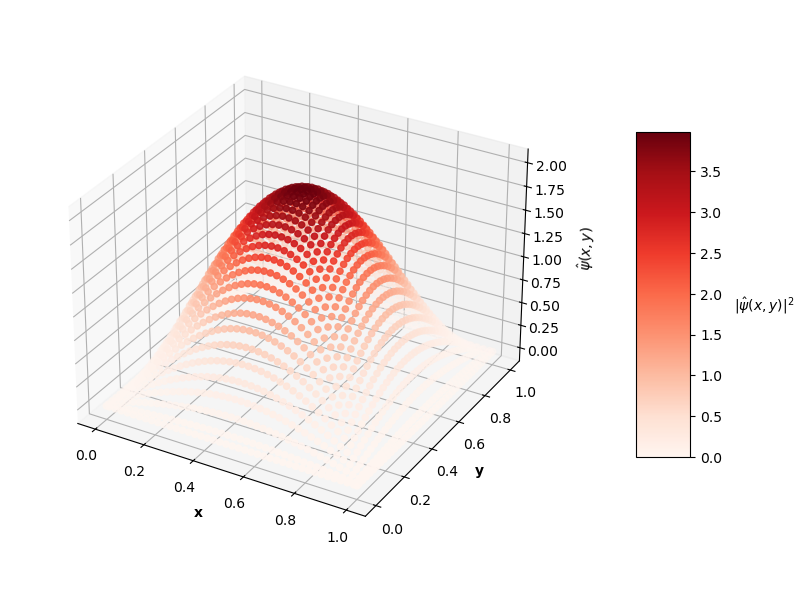

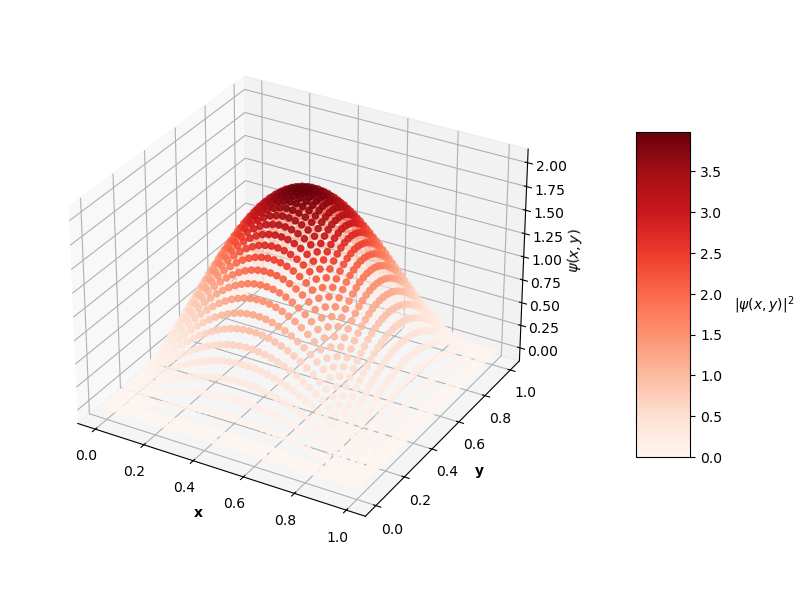

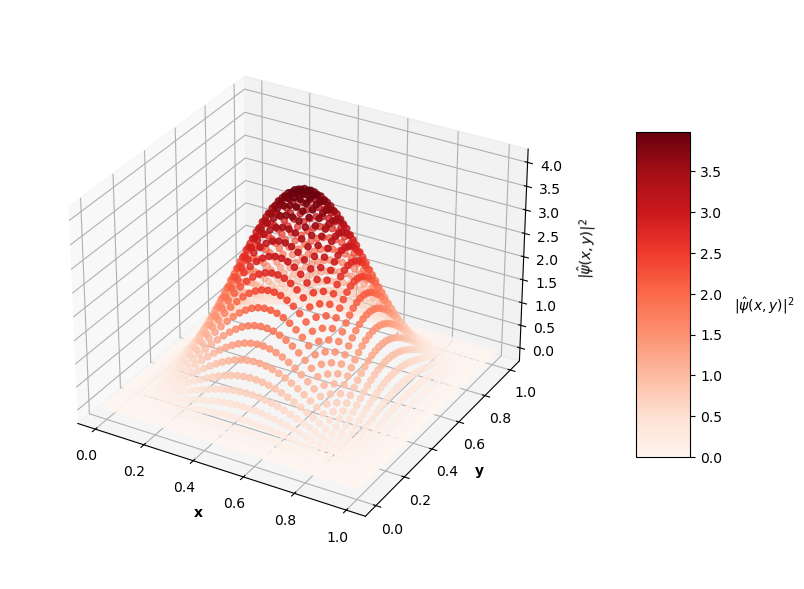

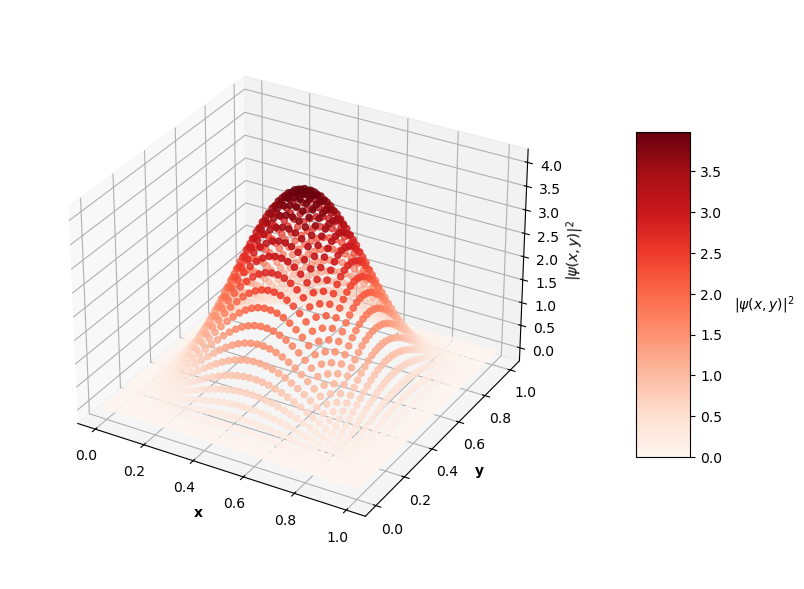

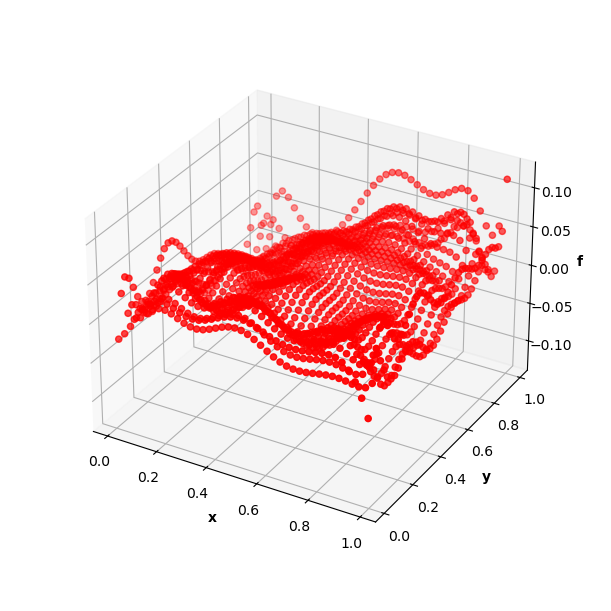

max f = 0.11525364840092034
min f = -0.12208939071904734

PINN saved on epoch 149246
E = 24.674011002723397
loss_ovr = 0.02743882361481395
loss_ovr_no_reg = 0.002450469330486969
loss_f = 0.0016639472465125214
loss_bc = 0.0007865220839744478
u_trivial_penalty = 0.024988354284326983
flip val = -1.0
flipped sign = True
MSE = 0.000496608971420455


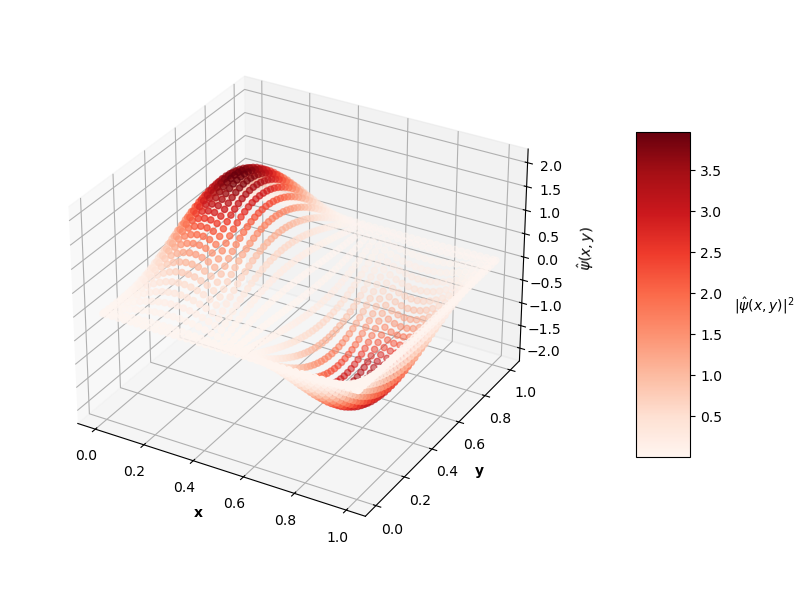

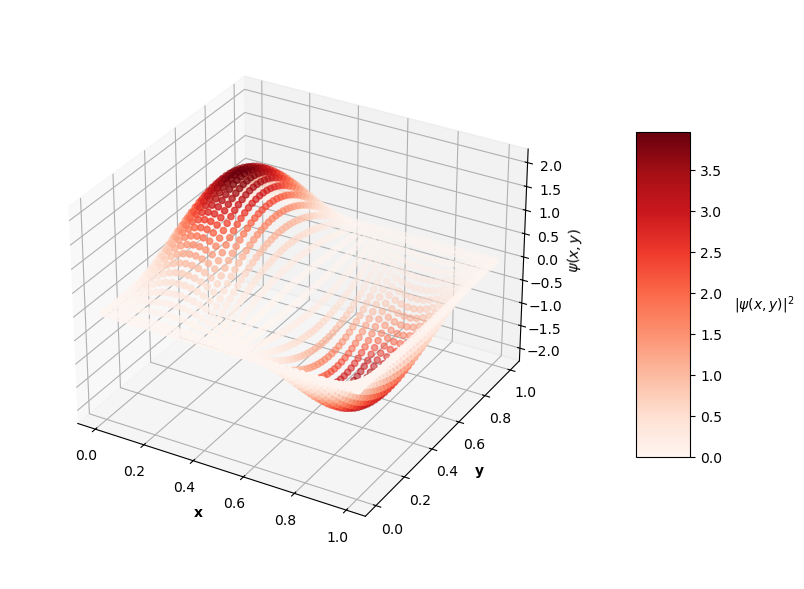

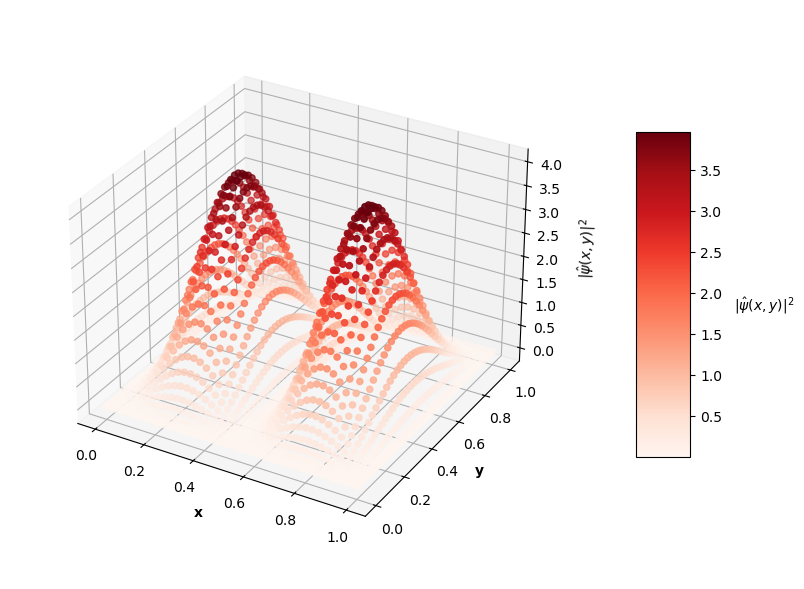

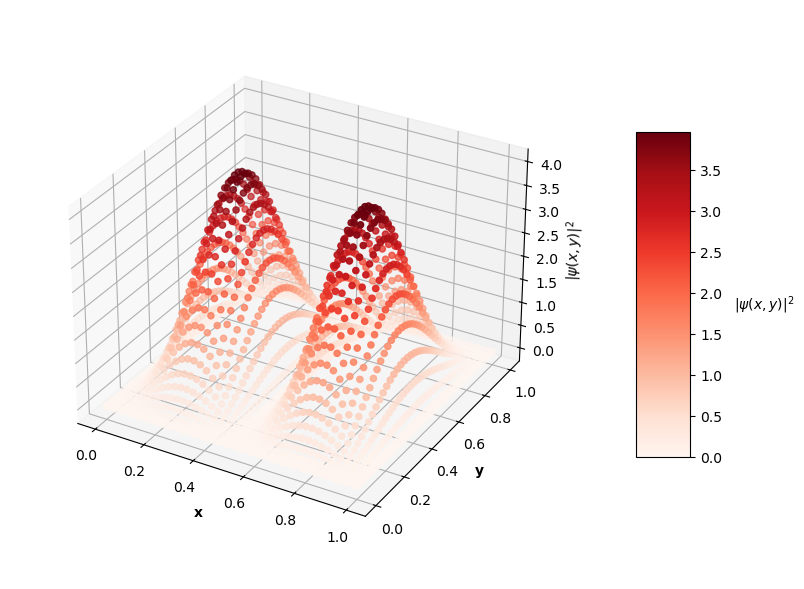

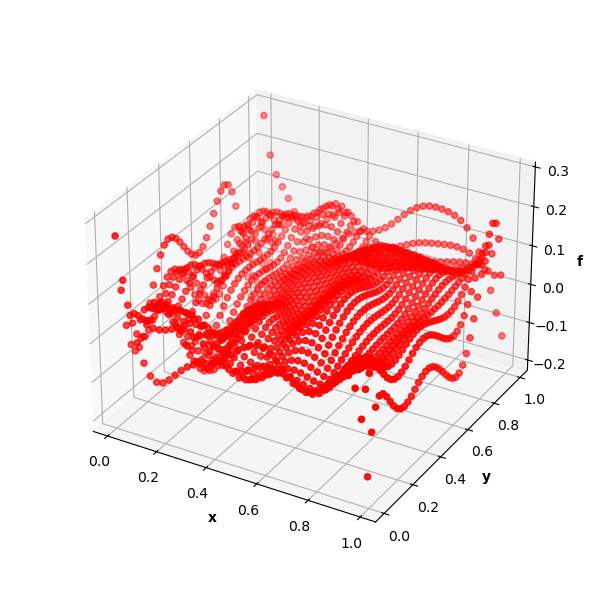

max f = 0.2778159477329095
min f = -0.19269061632693418

PINN saved on epoch 269965
E = 39.57841760435743
loss_ovr = 0.18970646241188083
loss_ovr_no_reg = 0.034695505527618145
loss_f = 0.026852553587601136
loss_bc = 0.007842951940017011
u_trivial_penalty = 0.1550109568842627
flip val = -1.0
flipped sign = True
MSE = 0.002529442981129279


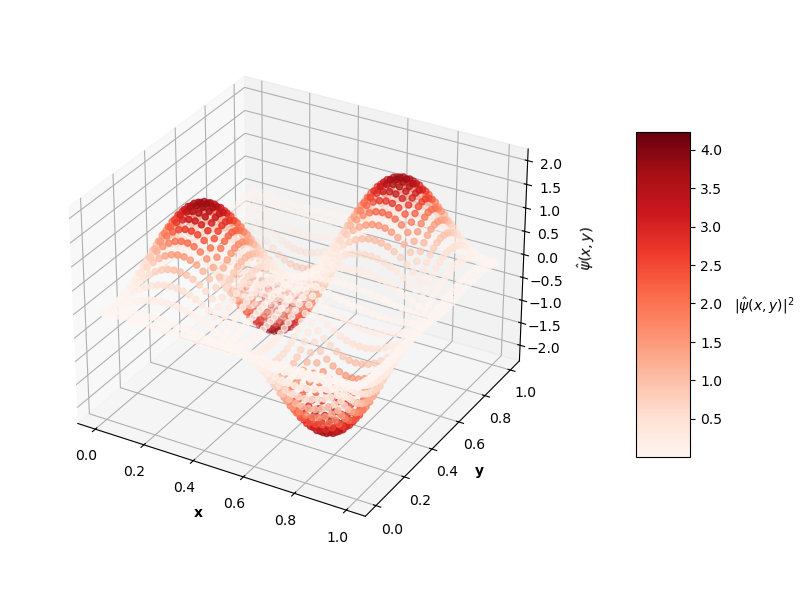

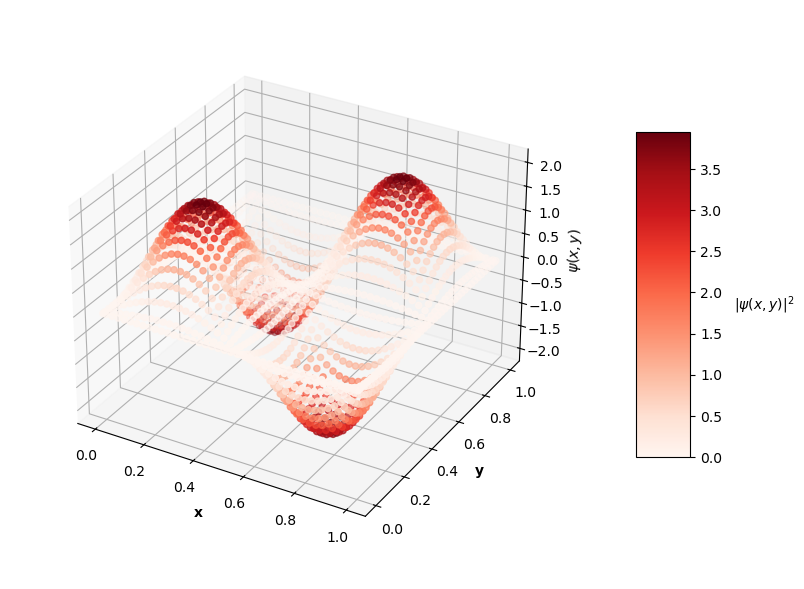

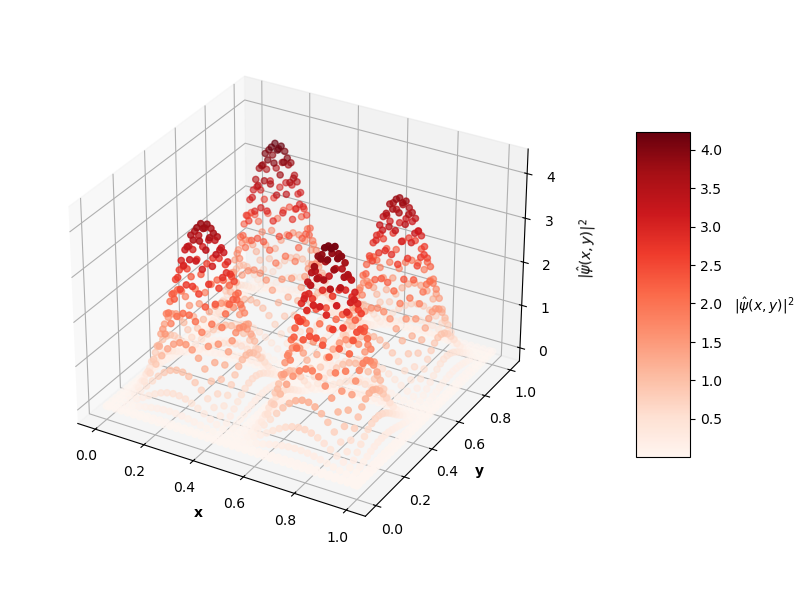

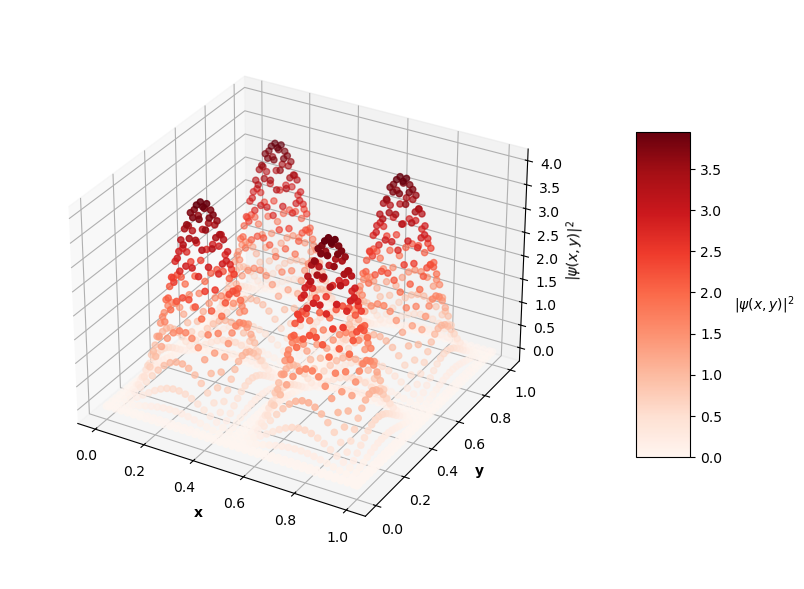

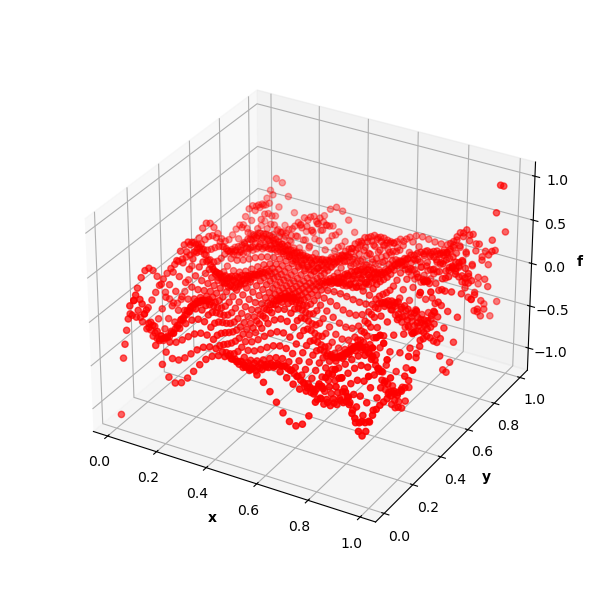

max f = 1.005360740959555
min f = -1.1121047356467093

PINN saved on epoch 359999
E = 49.448022005446795
loss_ovr = 0.5734908164388115
loss_ovr_no_reg = 0.1090007749787919
loss_f = 0.0576753336305719
loss_bc = 0.05132544134822001
u_trivial_penalty = 0.46449004146001965
flip val = 4.0
flipped sign = False
MSE = 1.798723978986318


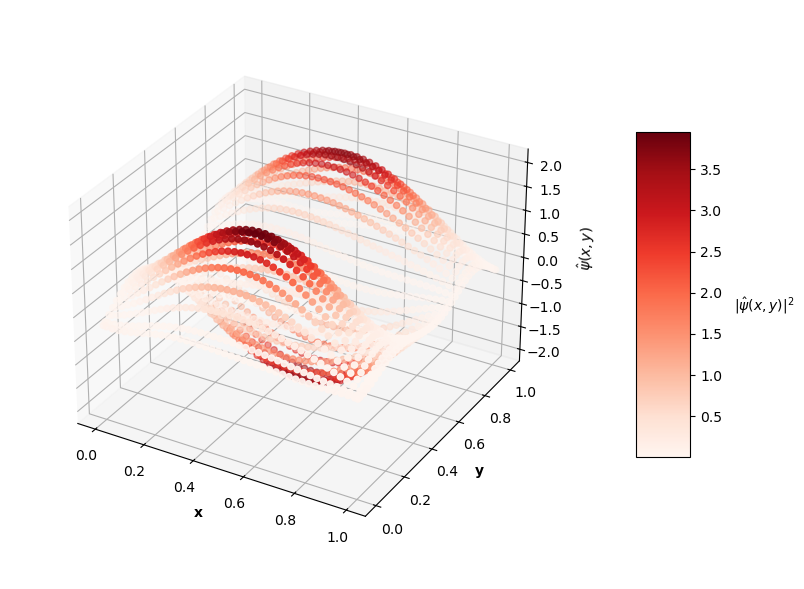

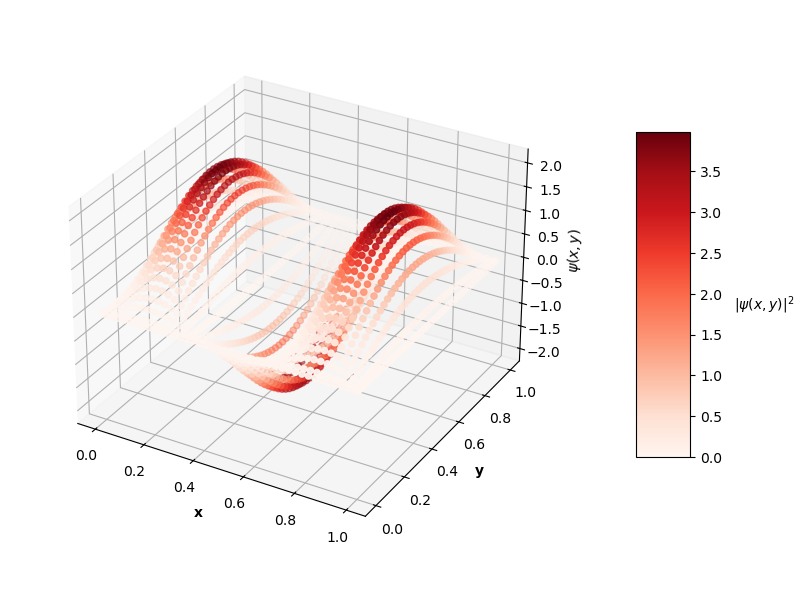

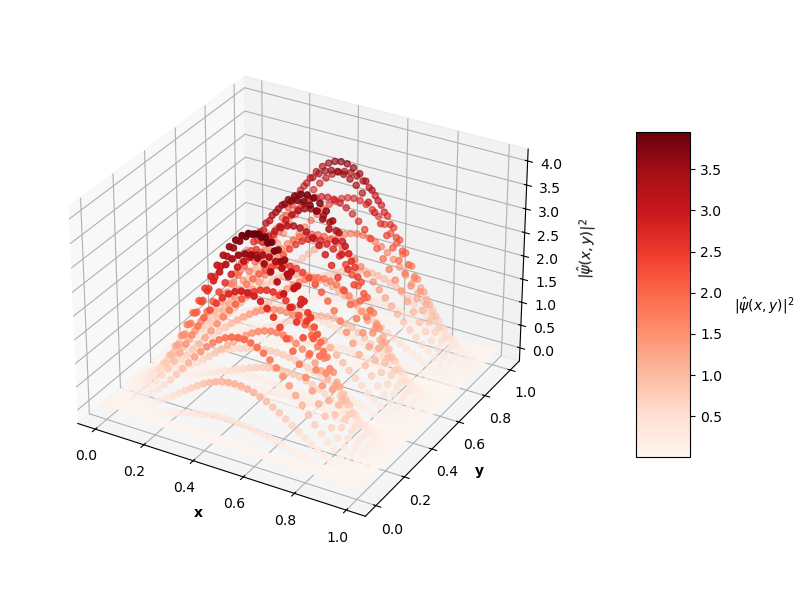

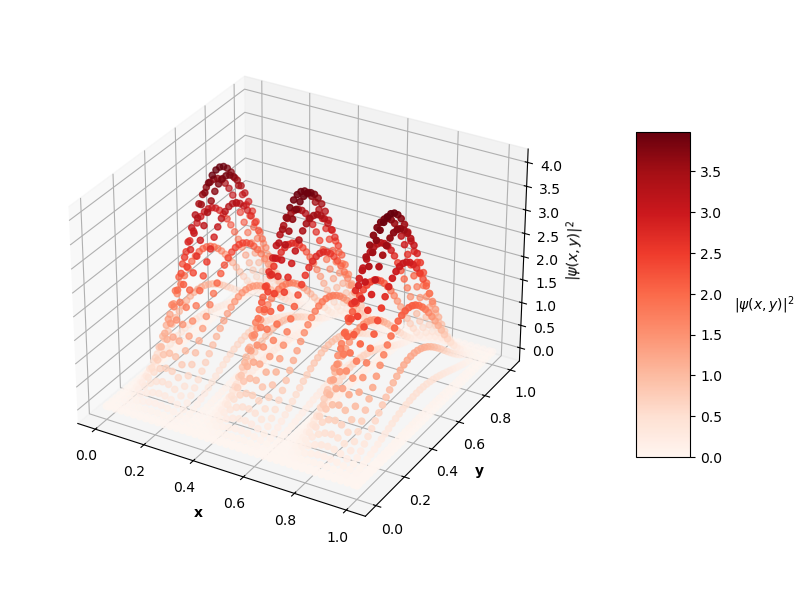

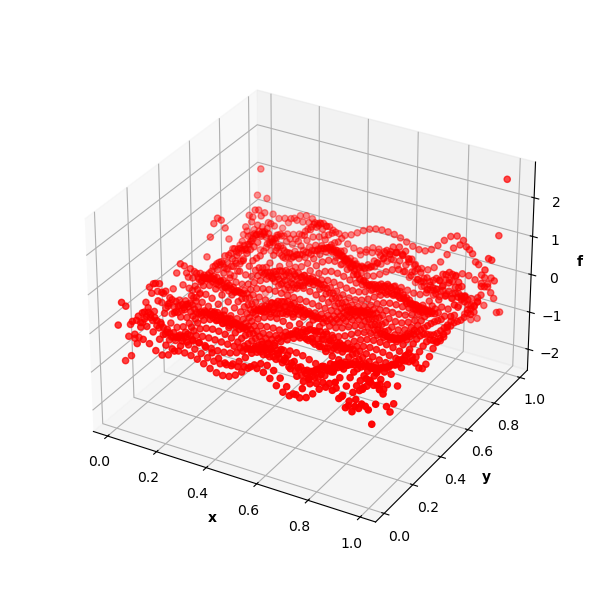

max f = 2.5641885293114797
min f = -2.218180585949043



In [13]:
for pinn_dict, nx_ny in zip(best_pinns, nx_ny_pairs):
    eval_pinn(pinn_dict, coll_data, bc_data, nx_ny[0], nx_ny[1])

### hack to get correct degenerate analytical plot for N=4 (ran later after training)

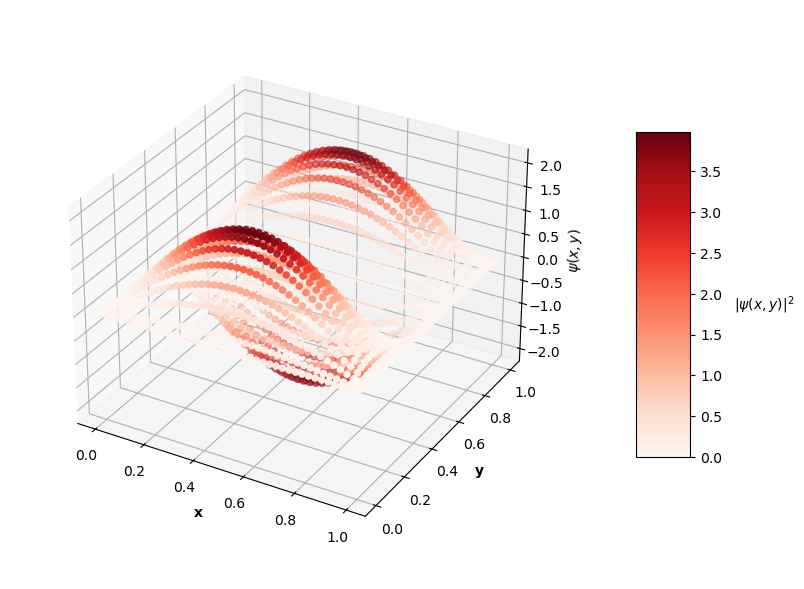

In [ ]:
def calc_analytical(x, y, n_x, n_y, L):
    return (2 / L) * np.sin(n_x * np.pi * x / L) * np.sin(n_y * np.pi * y / L)

def calc_pred_norm_const(approx_domain_pred_vec, d):
    return 1. / torch.sqrt(d**2 * torch.sum(approx_domain_pred_vec**2))

def eval_pinn(pinn_dict, coll_data, bc_data, nx, ny):
    # combine bc+coll data for inference
    xy_data = torch.concat([coll_data, bc_data])

    x = xy_data[:, 0].detach().cpu().numpy()
    y = xy_data[:, 1].detach().cpu().numpy()

    # analytical solution
    u_analytical = calc_analytical(x, y, nx, ny, L)
    u_analytical_prob_densities = u_analytical**2

    # analytical u
    plt.close()
    fig = plt.figure(figsize=(8, 6), constrained_layout=True)
    ax = fig.add_subplot(projection='3d')
    scatter_ax = ax.scatter(x, y, u_analytical, c=u_analytical_prob_densities, cmap="Reds")
    colorbar = fig.colorbar(scatter_ax, shrink=0.55, aspect=6, pad=0.1)
    colorbar.set_label(r"$|\psi(x,y)|^2$", labelpad=30)
    colorbar.ax.yaxis.label.set_rotation(0)
    ax.set_xlabel("x", weight="bold")
    ax.set_ylabel("y", weight="bold")
    ax.set_zlabel(r"$\psi(x,y)$", weight="bold")
    ax.set_box_aspect(aspect=None, zoom=0.9)  
    plt.show()

eval_pinn(None, coll_data, bc_data, 1, 3)